In [ ]:
from mlfunctions import MNISTNet, cache, do_fit, MNISTLoss
import numpy as np
import torch.optim as optim
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp
from meta_module import MetaLinear, MetaModule
import functools

In [ ]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]


@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results


In [ ]:

# NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']
COLORS = ["red", "blue", "green", "purple", "orange"]
# LEARNING_RATES = [0.01, 0.003, 0.03, 1.0]
# N_TESTS = 1
# N_EPOCHS = 20

# fit_data = np.zeros((N_TESTS, N_EPOCHS, len(OPT_NAMES) + 1))
# for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, LEARNING_RATES)):
#     np.random.seed(0)
#     fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=N_EPOCHS, **extra_kwargs))

# fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, N_EPOCHS, N_EPOCHS, out_mul=0.1, should_train=False))

# Plotting 

Data is loaded for the 2-layer traiend model
![https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f574f3c5-de8f-4c8d-bd76-16b6750ad510/Untitled.png](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f574f3c5-de8f-4c8d-bd76-16b6750ad510/Untitled.png)

(number of tests, number of epochs (timesteps), number of optimizers)

In [ ]:
import pandas as pd
def to_long_form(data_arr):
    records = []
    for i in range(fit_data.shape[0]):
        for j in range(fit_data.shape[1]):
            for k in range(fit_data.shape[2]):
                records.append((i, j, condition[k], fit_data[i, j, k]))
    df = pd.DataFrame.from_records(records,columns=['test', 'Steps', 'Optimizer', 'Loss'] )
    return df

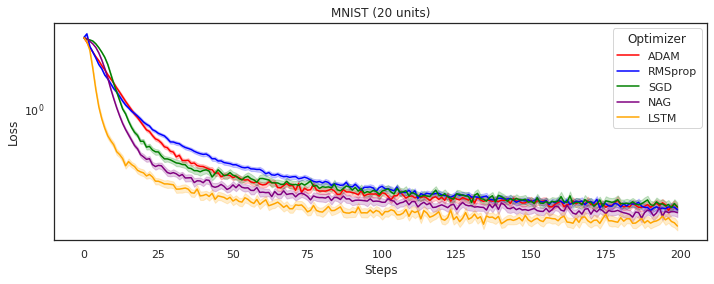

In [ ]:


fit_data = np.load('mnist-data-fit.npy')
# fit_data = np.load('fit-data-mnist-2layers.npy')

# fit_data_averaged = np.average(fit_data,axis = 0)
# fit_data_SD = np.var(fit_data,axis = 0)
condition=OPT_NAMES + ['LSTM']
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (20 units)")

plt.show()

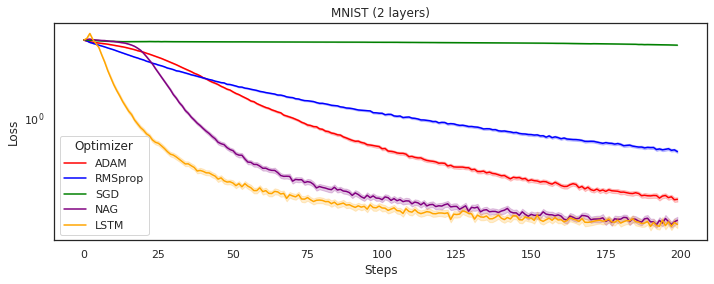

In [ ]:
fit_data = np.load('fit-data-mnist-2layers.npy')
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (2 layers)")
plt.show()

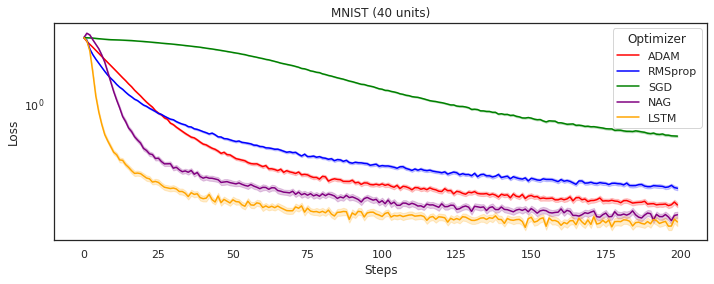

In [ ]:
fit_data = np.load('fit-data-mnist-big.npy')
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (40 units)")
plt.show()

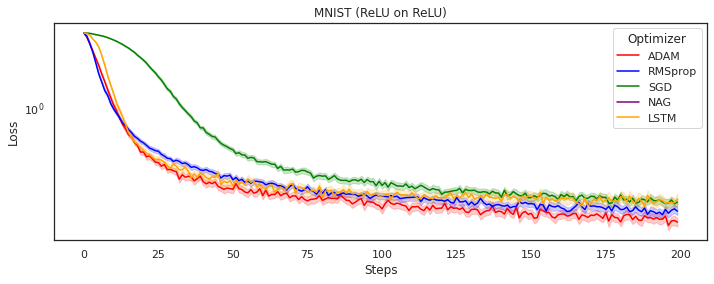

In [ ]:
fit_data = np.load('fit-data-mnist-relu.npy')
fit_data_relu = np.load("mnist-relu-fit-relu.npy")
fit_data[:100, :, len(OPT_NAMES)] = fit_data_relu[:,:, len(OPT_NAMES)]
fit_data = fit_data[:100, :, :]
fit_data[:,:, len(OPT_NAMES)-1] = 0
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (ReLU on ReLU)")
plt.show()

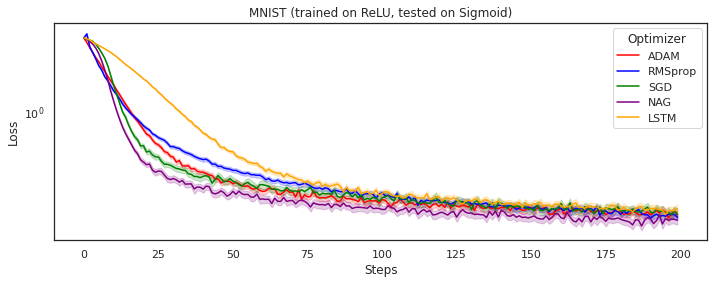

In [ ]:

fit_data_relu = np.load('mnist-relu-fit.npy')
fit_data = np.load("mnist-data-fit.npy")
fit_data[:, :, len(OPT_NAMES)] = fit_data_relu[:,:, len(OPT_NAMES)]
# fit_data = np.load('fit-data-mnist-2layers.npy')

# fit_data_averaged = np.average(fit_data,axis = 0)
# fit_data_SD = np.var(fit_data,axis = 0)
condition=OPT_NAMES + ['LSTM']
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (trained on ReLU, tested on Sigmoid)")
plt.show()

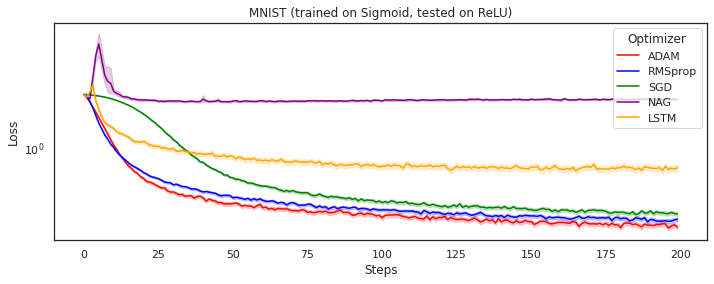

In [ ]:

fit_data = np.load("fit-data-mnist-relu.npy")

condition=OPT_NAMES + ['LSTM']
df = to_long_form(fit_data)
axis = sns.lineplot(data=df, x='Steps', y='Loss', hue='Optimizer', ci=95, palette=COLORS)
plt.gcf().set_figwidth(11.7)
plt.yscale('log')
plt.title("MNIST (trained on Sigmoid, tested on ReLU)")
plt.show()

In [ ]:
print(fmri)

     subject  timepoint event    region    signal
0        s13         18  stim  parietal -0.017552
1         s5         14  stim  parietal -0.080883
2        s12         18  stim  parietal -0.081033
3        s11         18  stim  parietal -0.046134
4        s10         18  stim  parietal -0.037970
...      ...        ...   ...       ...       ...
1059      s0          8   cue   frontal  0.018165
1060     s13          7   cue   frontal -0.029130
1061     s12          7   cue   frontal -0.004939
1062     s11          7   cue   frontal -0.025367
1063      s0          0   cue  parietal -0.006899

[1064 rows x 5 columns]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b20e1b0b-d80b-4297-abae-d3a4799140e7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>